# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Convert a model

In [3]:
import numpy
from skl2onnx import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.9999"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.4019831717014313
      floats: 1.3700511455535889
      floats: -2.1321938037872314
      floats: -0.9685680270195007
      floats: 0.26388299465179443
      floats: -1.3623178005218506
      floats: 0.6157799363136292
      floats: -1.229750394821167
      floats: -1.419705867767334
      floats: -1.4254604578018188
      floats: 2.1078641414642334
      floats: 2.2392592430114746
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.24816110730171204
      floats: 0.8739975094795227
      floats: -0.9850784540176392
      type: 

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  orientation=portrait;
  ranksep=0.25;
  nodesep=0.05;

  X [shape=box color=red label="X\nfloat((1, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((1,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.40198317  1.37...\nintercepts=[ 0.24816111  0.8739...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)  # add local=True if nothing shows up

## magic commands

The module implements a magic command to easily display graphs.

In [8]:
%load_ext mlprodict

In [9]:
# add -l 1 if nothing shows up
%onnxview model_onnx

## runtime

Let's compute the prediction using a Python runtime.

In [10]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

{0: array([4.57370295e-03, 3.72453788e-02, 4.19822272e-04, 9.03357004e-01,
        9.97878374e-04]),
 1: array([0.55617608, 0.71126721, 0.27068349, 0.09658436, 0.15483594]),
 2: array([4.39250219e-01, 2.51487415e-01, 7.28896684e-01, 5.86393911e-05,
        8.44166177e-01])}

In [11]:
import pandas
prob = pandas.DataFrame(list(prob)).values
prob[:5]

array([[4.57370295e-03, 5.56176078e-01, 4.39250219e-01],
       [3.72453788e-02, 7.11267207e-01, 2.51487415e-01],
       [4.19822272e-04, 2.70683494e-01, 7.28896684e-01],
       [9.03357004e-01, 9.65843566e-02, 5.86393911e-05],
       [9.97878374e-04, 1.54835944e-01, 8.44166177e-01]])

Which we compare to the original model.

In [12]:
clr.predict_proba(X_test)[:5]

array([[4.57370089e-03, 5.56176101e-01, 4.39250198e-01],
       [3.72453661e-02, 7.11267236e-01, 2.51487398e-01],
       [4.19822016e-04, 2.70683515e-01, 7.28896663e-01],
       [9.03356992e-01, 9.65843685e-02, 5.86393836e-05],
       [9.97877778e-04, 1.54835965e-01, 8.44166157e-01]])

Some time measurement...

In [13]:
%timeit clr.predict_proba(X_test)

62.4 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit sess.run({'X': X_test})['output_probability']

45.6 µs ± 8.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With one observation:

In [15]:
%timeit clr.predict_proba(X_test[:1])

54.5 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

31.2 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%matplotlib inline

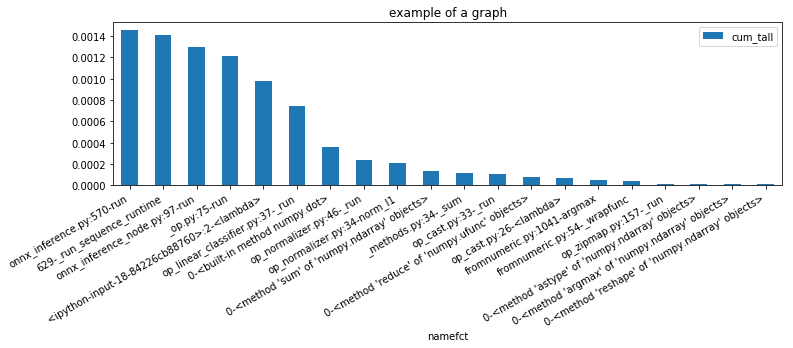

In [18]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');